# AIoT Project 2023

In [105]:
import os

# basic data engineering
import pandas as pd
import numpy as np
import scipy

# plotting
import matplotlib.pyplot as plt
# import seaborn as sns

# db
import pymongo

# configs & other
import yaml
# from tqdm.notebook import tqdm_notebook
from datetime import datetime
from time import time

# from psynlig import pca_explained_variance_bar

# utils processing
from utils import sliding_window_pd
from utils import apply_filter
from utils import filter_instances
from utils import flatten_instances_df
from utils import df_rebase
from utils import rename_df_column_values

# utils visualization
from utils_visual import plot_instance_time_domain
from utils_visual import plot_instance_3d
from utils_visual import plot_np_instance
from utils_visual import plot_heatmap
from utils_visual import plot_scatter_pca

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Start time of execution

In [106]:
time_start = time()

## Load configuration

In [107]:
config_path = "config.yml"

with open(config_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [108]:
client = pymongo.MongoClient(config["client"])

In [109]:
db = client[config["db"]]
coll = db[config["col"]]

In [110]:
found_keys = coll.distinct("label")
print("Existing DB keys:", found_keys)

Existing DB keys: ['α', 'β', 'γ', 'δ']


In [111]:
data = list(coll.find({}, {'label': 1, 'data': 1, 'datetime': 1}))
df = pd.DataFrame(data)
print(df.iloc[0])

_id                                  64711a452b40615a54bba987
data        {'acc_x': [0.136, 0.13, 0.121, 0.135, 0.145, 0...
label                                                       α
datetime                              2023-05-17 20:44:55.691
Name: 0, dtype: object


## Barplot (Mean Length of data per Label)

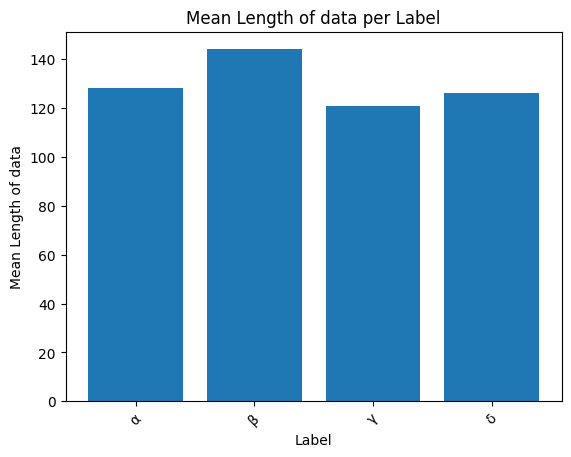

In [112]:
# distinct labels
labels = df["label"].unique() # type: ignore
# get data length for each label
label_mean_lengths = df.groupby('label')['data'].apply(lambda x: x.apply(lambda arr: len(arr['acc_x'])).mean())

# Create a bar plot
plt.bar(label_mean_lengths.index, label_mean_lengths.values) # type: ignore

# Set labels and title
plt.xlabel('Label')
plt.ylabel("Mean Length of data")
plt.title("Mean Length of data per Label")

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

## Windows

In [113]:
sl  = config["sliding_window"]
w = []

for x in df["data"]:
    df_x = pd.DataFrame(x) # type: ignore
    windows = sliding_window_pd(df_x, ws= sl["ws"], overlap= sl["overlap"], w_type= sl["w_type"], w_center= sl["w_center"], print_stats= sl["print_stats"])
    w.append(pd.Series(windows))

df["windows"] = w

30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True
30 15 hann True


## Barlpot of the number of windows per label

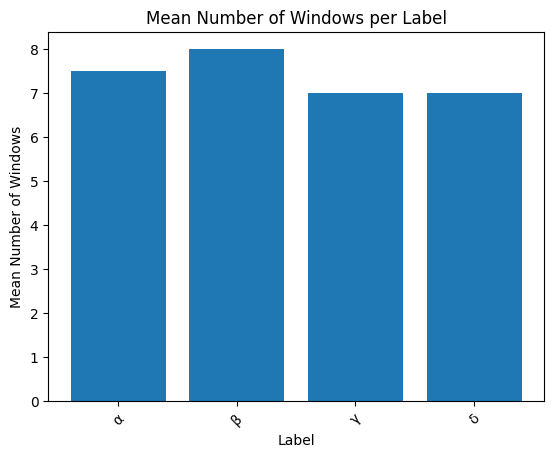

In [114]:
# distinct labels
labels = df["label"].unique() # type: ignore
# get data length for each label
windows_mean_lengths = df.groupby('label')['windows'].apply(lambda x: x.apply(lambda arr: len(arr)).mean())

# Create a bar plot
plt.bar(windows_mean_lengths.index, windows_mean_lengths.values) # type: ignore

# Set labels and title
plt.xlabel('Label')
plt.ylabel("Mean Number of Windows")
plt.title("Mean Number of Windows per Label")

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

## Apply filter

In [115]:
# Apply a low filter to the data
df_filtered = df.copy()

for i,x in enumerate(df["windows"]):
    for j,y in enumerate(x): # type: ignore
        for k in y:
            df_filtered["windows"][i][j][k] = apply_filter(y[k])

In [116]:
# get list from df["windows"]
windows = df["windows"].tolist() # type: ignore
# ilter_instances(instances_list, order, wn, filter_type)
filtered_windows = filter_instances(windows, order= config["filter"]["order"], wn= config["filter"]["wn"], filter_type= config["filter"]["type"])
# print("windows:", type(windows), len(windows))

Number of filtered instances in the list: 7


## Transform the list of DataFrames to NumPy array

Transform the list of DataFrames to NumPy array that contains the windows: (instances, x, y)

In [117]:
# np_filtered_windows = []

# for x in filtered_windows:
#     np_filtered_windows.append(np.array(x))

# print(len(np_filtered_windows))
# np_filtered_windows = np.array(np_filtered_windows)
# print(np_filtered_windows[0][0].shape)
new_df = flatten_instances_df(filtered_windows)
# print(new_df[0][0])

## Flatten the 2D window instances

Flatten the X NumPy array that contains the 2D window instances

In [118]:
X = np.array(new_df)

# # Fill None values with 0
for i,x in enumerate(X):
    for j,y in enumerate(x):
        if y is None:
            X[i][j] = np.zeros(X[i][j-1].shape)
            # print(X[i][j].shape)

# print(X[0])

# print(X[0][0].shape)
# flattened_X = np.concatenate([x.flatten() for x in X], axis=0).reshape(2, -1)
# Flatten every instance inside X array
flattened_X = np.array([np.array([x.flatten() for x in row]) for row in X])
print(flattened_X.shape)
# flattened_X = np.array([x.flatten() for row in X for x in row if x is not None])
# flattened_X = np.array([x.flatten() for row in X for x in row if x is not None])
# print(flattened_X[0].shape)
# print(X[0][0].flatten().shape)
# print(X.shape)
y = np.array(df["label"].tolist()) # type: ignore
# turn labels into numbers
y = pd.factorize(y)[0]
print(y.shape)
# print(flattened_X[0][0].shape)

(7, 8, 180)
(7,)


## Train/Test split

In [172]:
from sklearn.model_selection import train_test_split

In [179]:
X_train, X_test, y_train, y_test = train_test_split(flattened_X, y, test_size=0.20, shuffle=True, random_state=42)

## Scaling

In [180]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [181]:
# Standard scaler for X
scaler = StandardScaler()

# Reshape data to 2d array
train_data_scaled = np.reshape(X_train, (X_train.shape[0] * X_train.shape[1], X_train.shape[2]))
test_data_scaled = np.reshape(X_test, (X_test.shape[0] * X_test.shape[1], X_test.shape[2]))

# Fit on training set only.
scaler.fit(train_data_scaled)

# Apply transform to both the training set and the test set.
train_data_scaled = scaler.transform(train_data_scaled)
test_data_scaled = scaler.transform(test_data_scaled)

# reshape back to 3d
train_data_scaled = np.reshape(train_data_scaled, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
test_data_scaled = np.reshape(test_data_scaled, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

X_train = train_data_scaled
X_test = test_data_scaled


print(train_data_scaled.shape)
print(test_data_scaled.shape)

(5, 8, 180)
(2, 8, 180)


## Transform to 2D again

## Dimensionality Reduction with PCA using the 1D (flattened) data

In [182]:
# add transformers
from sklearn.decomposition import PCA

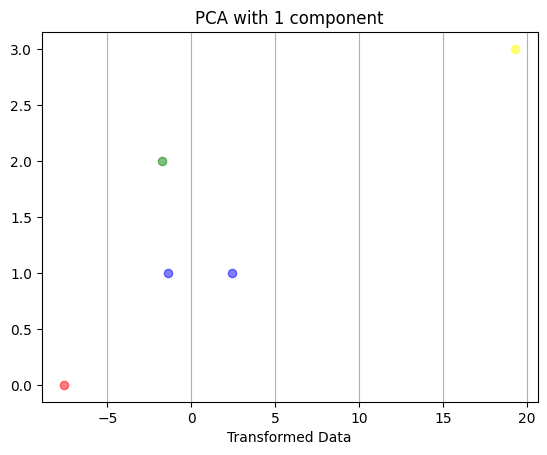

In [186]:
# PCA with 1 component
pca = PCA(n_components=1)

# Transform data and plot
fig, ax = plt.subplots()
transformed_data = []
for i, x in enumerate(X_train):
    transformed_x = pca.fit_transform(x)
    transformed_data.append(transformed_x[0])

colors = {0: "red", 1: "blue", 2: "green", 3: "yellow", 4: "orange", 5: "purple", 6: "pink", 7: "brown", 8: "black", 9: "gray"}

for i,x in enumerate(transformed_data):
    ax.scatter(x, y_train[i], alpha=0.5, label="PCA", color=colors[y_train[i]])
ax.set_xlabel("Transformed Data")
ax.set_title("PCA with 1 component")
ax.xaxis.grid(True)
plt.show()




### PCA with 2 Components

In [184]:
pca2d.fit(data)

NameError: name 'pca2d' is not defined

In [ ]:
pca_explained_variance_bar(pca_object, alpha=0.8)

In [ ]:
plot_heatmap(df=DATAFRAME)

### PCA with 3 Components

### PCA with X% of the variance of the dataset, for training the statistical AI Models

## Classifier - Statistical Learning

### Apply simple classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

### Evaluate simple classifier

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from sklearn.metrics import classification_report

### Apply optimization with Grid Search and Cross-validation

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

### Evaluate optimized classifier

## Classifier - Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten

In [ ]:
input_data_shape = X_train_2d[0].shape
print("Type of the input shape object:", type(input_data_shape))
X_train_2d[0].shape

In [ ]:
y_np_array = np.array(y)
n_outputs = len(np.unique(y_np_array))
print("Number of outputs (classes) the model to predict:", n_outputs)

### Create the Neural Network (NN) Architecture and instantiate the model

In [ ]:
model = Sequential()

"""
BUILD YOUR MODEL ARCHITECTURE HERE
"""

model.add(Dense(n_outputs, activation="softmax"))

Plot the Architecture of ot the TensorFlow model

Plot the summary of the TensorFlow model

### Build the NN model

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["ADD METRIC"])

In [ ]:
from utils import encode_labels

### Train the NN model

### Evaluate the model on the test data

### Plot and interpret the learning curves: Loss and Accuracy based on the training and validation sets